In [4]:
import torch
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

import torch.nn as nn

Projection matrix W:
 tensor([[-0.4193, -0.7429],
        [-0.9079,  0.6694]])
Shape of projected data: torch.Size([200, 2])


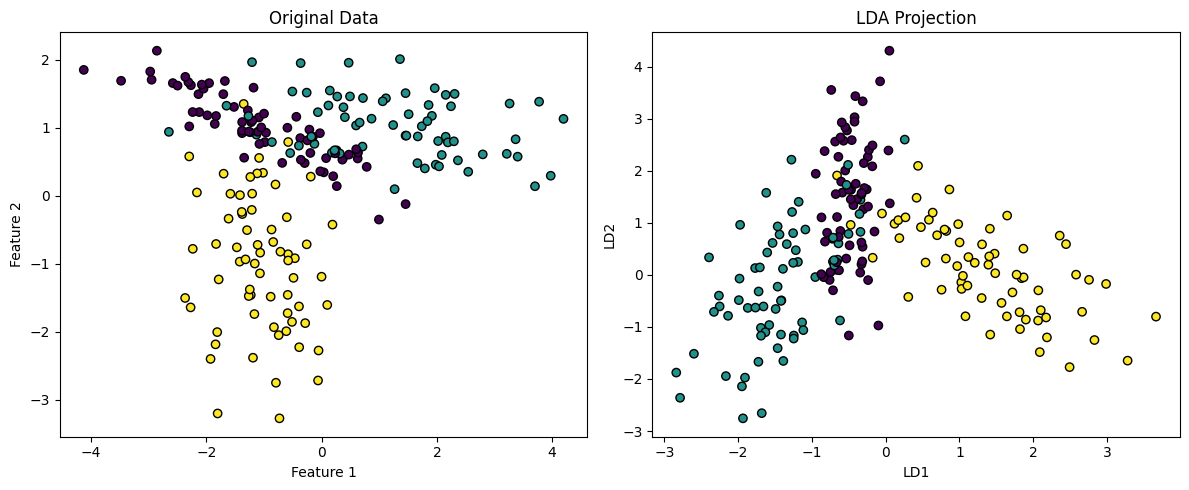

In [11]:
# 1. Generate a toy dataset with 3 classes and 2 features.
# Using sklearn's make_classification, we obtain features X and labels y.
# Math: X ∈ ℝ^(200×2), y ∈ {0,1,2} with 200 samples from 3 classes.
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, n_classes=3)

# Convert the numpy data into PyTorch tensors for further computations.
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int64)

# 2. Compute the overall mean of the dataset.
# Math: μ_overall = (1/N) ∑_{i=1}^N x_i
overall_mean = torch.mean(X_tensor, dim=0)

# 3. Initialize scatter matrices for LDA.
n_features = X_tensor.shape[1]
# Within-class scatter matrix: S_w = ∑_{c} ∑_{x in class c} (x - μ_c)(x - μ_c)^T
S_w = torch.zeros((n_features, n_features))
# Between-class scatter matrix: S_b = ∑_{c} n_c (μ_c - μ_overall)(μ_c - μ_overall)^T
S_b = torch.zeros((n_features, n_features))

# 4. Compute S_w and S_b by iterating over each class.
classes = torch.unique(y_tensor)
for cls in classes:
    # Select samples belonging to the current class c.
    X_cls = X_tensor[y_tensor == cls]
    # Compute mean of class c: μ_c = (1/n_c) ∑_{x in class c} x
    cls_mean = torch.mean(X_cls, dim=0)
    
    # Math for within-class scatter:
    # For class c: S_w(c) = ∑_{x in class c} (x - μ_c)(x - μ_c)^T.
    diff = X_cls - cls_mean
    S_w += diff.t() @ diff  # Aggregate for all classes

    # Math for between-class scatter:
    # S_b(c) = n_c (μ_c - μ_overall)(μ_c - μ_overall)^T.
    n_cls = X_cls.shape[0]
    mean_diff = (cls_mean - overall_mean).unsqueeze(1)  # Column vector representation.
    S_b += n_cls * (mean_diff @ mean_diff.t())

# 5. Solve the generalized eigenvalue problem for LDA.
# Mathematical formulation: find eigenpairs (λ, v) satisfying S_w^(-1) * S_b * v = λ * v.
# torch.linalg.eig may return complex numbers so we take the real parts.
eigvals, eigvecs = torch.linalg.eig(torch.linalg.inv(S_w) @ S_b)
eigvals = eigvals.real
eigvecs = eigvecs.real

# 6. Sort eigenvectors by descending eigenvalues.
# The eigenvalues indicate the discriminatory power along their eigenvectors.
sorted_indices = torch.argsort(eigvals, descending=True)
eigvecs = eigvecs[:, sorted_indices]

# For LDA, the maximum number of discriminative directions is (number of classes - 1).
k = len(classes) - 1
W = eigvecs[:, :k]  # Projection matrix composed of the top k eigenvectors.

# 7. Project the original data onto the LDA subspace.
# Math: X_lda = X * W, where W reduces the dimensionality to k.
X_lda = X_tensor @ W

print("Projection matrix W:\n", W)
print("Shape of projected data:", X_lda.shape)

# 8. Plot both the original data and its LDA projection.
plt.figure(figsize=(12, 5))

# Left plot: the original 2D space.
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Right plot: data projected onto the LDA space.
plt.subplot(1, 2, 2)
plt.title("LDA Projection")
if k == 1:
    # For a 1D projection, use a single axis (with zeros as the second coordinate).
    plt.scatter(X_lda[:, 0], torch.zeros_like(X_lda[:, 0]), c=y, cmap='viridis', edgecolor='k')
    plt.xlabel("LD1")
else:
    # For k >= 2, plot the first two linear discriminants.
    plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.xlabel("LD1")
    plt.ylabel("LD2")

plt.tight_layout()
plt.show()


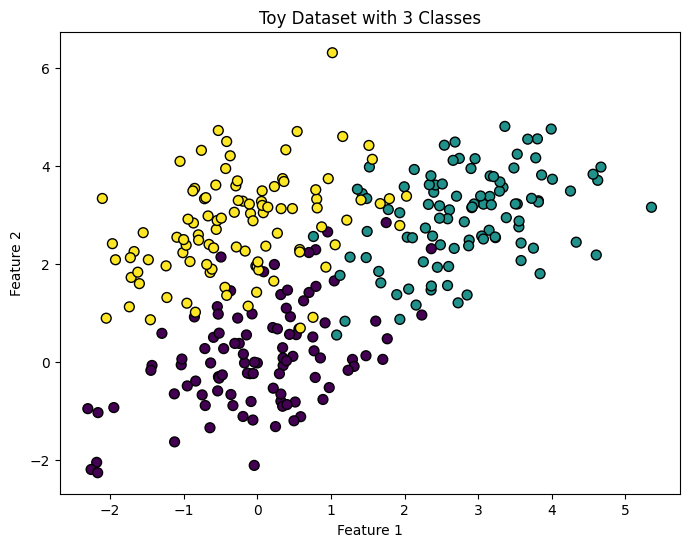

Classification accuracy: 0.9066666666666666


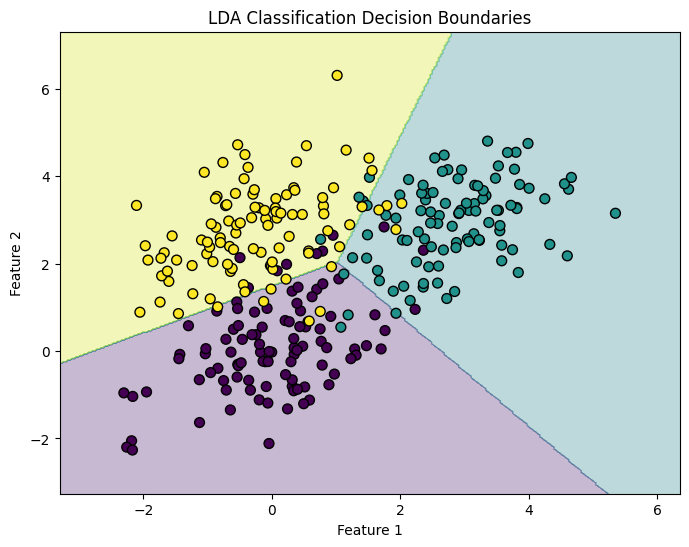

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Generate the Toy Dataset
# -------------------------------


n_samples = 100  # per class
means = {
    0: np.array([0, 0]),
    1: np.array([3, 3]),
    2: np.array([0, 3])
}
# Define a common covariance matrix for all classes
cov = np.array([[1, 0.5],
                [0.5, 1]])

# Generate samples for each class
X_list, y_list = [], []
for cls in means:
    X_cls = np.random.multivariate_normal(means[cls], cov, size=n_samples)
    y_cls = np.full(n_samples, cls)
    X_list.append(X_cls)
    y_list.append(y_cls)

# Combine the data from all classes
X = np.vstack(X_list)
y = np.concatenate(y_list)

# Visualize the generated dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)
plt.title("Toy Dataset with 3 Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# -------------------------------
# 2. Compute Class Statistics
# -------------------------------
classes = np.unique(y)
n_total, n_features = X.shape

# Estimate class priors (here, uniform since the dataset is balanced)
priors = {cls: np.mean(y == cls) for cls in classes}

# Compute class means
class_means = {cls: np.mean(X[y == cls], axis=0) for cls in classes}

# Compute the pooled covariance matrix (using all data)
Sigma = np.zeros((n_features, n_features))
for cls in classes:
    X_cls = X[y == cls]
    diff = X_cls - class_means[cls]
    Sigma += diff.T @ diff
Sigma /= (n_total - len(classes))  # unbiased estimate

# Alternatively, if you know the true covariance, you could use `cov`

# Invert the covariance matrix for the discriminant function
Sigma_inv = np.linalg.inv(Sigma)

# -------------------------------
# 3. Define the LDA Discriminant Function
# -------------------------------
def delta(x, mu, prior, Sigma_inv):
    """
    Compute the LDA discriminant function for a single data point.
    
    Parameters:
      x       : Data point (1D array).
      mu      : Mean vector for the class.
      prior   : Prior probability for the class.
      Sigma_inv: Inverse of the pooled covariance matrix.
      
    Returns:
      The discriminant score for the given class.
    """
    return x @ Sigma_inv @ mu - 0.5 * (mu @ Sigma_inv @ mu) + np.log(prior)

# -------------------------------
# 4. Classify the Data Points
# -------------------------------
y_pred = []
for x in X:
    # Compute discriminant score for each class
    scores = [delta(x, class_means[cls], priors[cls], Sigma_inv) for cls in classes]
    # Assign the class with the highest score
    y_pred.append(classes[np.argmax(scores)])
y_pred = np.array(y_pred)

# Compute and display accuracy
accuracy = np.mean(y_pred == y)
print("Classification accuracy:", accuracy)

# -------------------------------
# 5. Visualize Decision Boundaries
# -------------------------------
# Create a meshgrid over the feature space
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict class for each grid point
grid_pred = []
for x in grid:
    scores = [delta(x, class_means[cls], priors[cls], Sigma_inv) for cls in classes]
    grid_pred.append(classes[np.argmax(scores)])
grid_pred = np.array(grid_pred).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_pred, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)
plt.title("LDA Classification Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
